<a href="https://colab.research.google.com/github/davidfague/Model_Reduction_Methods/blob/main/NMDASimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation for generating data for dendritic spike analysis
##Recorded Currents:

Na,K,Ca,ih,...

## synapse distribution:

10,000 random. will update to include more realistic algorithm

#### Download modules from Github

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 43.8 MB/s eta 0:00:00


In [2]:
!pip install neuron_reduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git clone https://github.com/davidfague/Model_Reduction_Methods.git

Cloning into 'Model_Reduction_Methods'...
remote: Enumerating objects: 814, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 814 (delta 18), reused 0 (delta 0), pack-reused 774
Receiving objects: 100% (814/814), 5.44 MiB | 14.86 MiB/s, done.
Resolving deltas: 100% (447/447), done.


In [4]:
%cd Model_Reduction_Methods/

#import reduction and expansion functions
from test_neuron_reduce.subtree_reductor_func import subtree_reductor
from cable_expander_func import cable_expander

#import recording functions
from stylized_module.recorder import Recorder

#import analysis functions
from utils import make_seg_df,generate_stylized_geometry,make_reduced_seg_df,plot_morphology,check_connectivity,generate_reduced_cell_seg_coords, create_seg_var_report,plot_seg_heatmap


# from modeling_module.synapses import Synapse, Listed_Synapse
from modeling_module.cell_model import cell_model

import pandas as pd

/content/Model_Reduction_Methods


In [5]:
%cd expand_example

/content/Model_Reduction_Methods/expand_example


In [6]:
# compile the mod files
!nrnivmodl mod

/content/Model_Reduction_Methods/expand_example
Mod files: "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> NMODL ../mod/Ca_LVAst.mod
 -> NMODL ../mod/CaDynamics_E2.mod
 -> NMODL ../mod/Ca_HVA.mod
 -> Compiling mod_func.cpp
Translating CaDynamics_E2.mod into /content/Model_Reduction_Methods/expand_example/x86_64/CaDynamics_E2.c
Thread Safe
 -> NMODL ../mod/epsp.mod
Translating Ca_HVA.mod into /content/Model_Reduction_Methods/expand_example/x86_64/Ca_HVA.c
Translating Ca_LVAst.mod into /content/Model_Reduction_Methods/expand_example/x86_64/Ca_LVAst.c
Thread Safe
Thread Safe
 -> NMODL ../mod/Ih.mod
Translating epsp.mod into /content/Model_Reduction_Methods/expand_example/x86_64/epsp.c
 -> NMODL ../mod/Im.mod
Thread Safe
 -

## Setup smiulation parameters

In [7]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import ipywidgets as widgets
from neuron import h
from scipy import signal
from IPython.display import display, clear_output
from ipywidgets import interactive_output, HBox, VBox, Label, Layout

from __future__ import division
from neuron import gui,h
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline


h.load_file('stdrun.hoc')
# h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)  # choose the set of mechanisms
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')


1.0

### Create a cell with reduced morphology

In [8]:
%ls

cell1.asc  example_expand.py  L5PCtemplate.hoc  x86_64/
Cell.hoc   L5PCbiophys3.hoc   mod/


In [9]:
# syn_to_netcon = {} # dictionary mapping netcons to their synapse
# for netcon in netcons_list: #fill in dictionary
#   syn = netcon.syn() # get the synapse that netcon points to
#   if syn in syn_to_netcon:
#       syn_to_netcon[syn].append(netcon) #add netcon to existing synapse key
#   else:
#       syn_to_netcon[syn] = [netcon] #create new synapse key using netcon as an item

In [10]:
# for netcon in syn_to_netcon[synapses_list[0]]:
#   print(netcon)

In [11]:

h.load_file('L5PCbiophys3.hoc') # load membrane biophysics
h.load_file("import3d.hoc") #load 3d morphology


# Create a cell object
h.load_file('L5PCtemplate.hoc') # load template for generating object
complex_cell = h.L5PCtemplate('cell1.asc') # generate object

#specify some parameters
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas

#Add synapses to the complex model
synapses_list, netstims_list, netcons_list, randoms_list = [], [], [] ,[]

all_segments = [i for j in map(list,list(complex_cell.apical)) for i in j] #+ [i for j in map(list,list(complex_cell.basal)) for i in j]
len_per_segment = np.array([seg.sec.L/seg.sec.nseg for seg in all_segments])
rnd = np.random.RandomState(10)
for i in range(10000):
    seg_for_synapse = rnd.choice(all_segments,   p=len_per_segment/sum(len_per_segment)) #choose a random segment with probability based on the length of segment
    synapses_list.append(h.Exp2Syn(seg_for_synapse))
    if rnd.uniform()<0.85: # 85% synapses are excitatory
        e_syn, tau1, tau2, spike_interval, syn_weight = 0, 0.3, 1.8,  1000/2.5, 0.0016
    else: #inhibitory case
        e_syn, tau1, tau2, spike_interval, syn_weight = -86, 1,   8,   1000/15.0, 0.0008
    #set synaptic varibales
    synapses_list[i].e, synapses_list[i].tau1, synapses_list[i].tau2 = e_syn, tau1, tau2
    #set netstim variables
    netstims_list.append(h.NetStim())
    netstims_list[i].interval, netstims_list[i].number, netstims_list[i].start, netstims_list[i].noise = spike_interval, 9e9, 100, 1
    #set random
    randoms_list.append(h.Random())
    randoms_list[i].Random123(i)
    randoms_list[i].negexp(1)
    netstims_list[i].noiseFromRandom(randoms_list[i])       
    #set netcon varibales 
    netcons_list.append(h.NetCon(netstims_list[i], synapses_list[i] ))
    netcons_list[i].delay, netcons_list[i].weight[0] = 0, syn_weight

In [12]:
#reduce each dendritic subtree to a single cable
reduced_cell, synapses_list, netcons_list, txt = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

In [13]:
#check synapses_list with netcons_list
for netcon in netcons_list:
  syn=netcon.syn()
  if syn not in synapses_list:
    print(syn, netcon)

In [14]:
#expand cables to idealized dendritic trees
sections_to_expand = [reduced_cell.hoc_model.apic[0]] # expand apical cylinder
furcations_x=[0.289004] #chose using the location of the mapped nexus branching segment
nbranches=[4]
reduced_dendritic_cell, synapses_list, netcons_list, txt = cable_expander(reduced_cell, sections_to_expand, furcations_x, nbranches, 
                                                                          synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

trunk_diam: 3.7176523208618155 |trunk_length: 698.0975964944687 |branch_diam: 1.475351301247016 |branch_length: 1081.9141048660235


In [15]:
#check synapses_list with netcons_list
for netcon in netcons_list:
  syn=netcon.syn()
  if syn not in synapses_list:
    print(syn, netcon)

In [16]:
# # try branching the branches - does not work yet
# sections_to_expand = [reduced_dendritic_cell.apic[1],reduced_dendritic_cell.apic[2],reduced_dendritic_cell.apic[3],reduced_dendritic_cell.apic[4]]
# furcations_x=[0.50,0.50,0.50,0.50]
# nbranches=[4,4,4,4]
# reduced_dendritic_cell, synapses_list, netcons_list, txt = cable_expander(reduced_dendritic_cell, sections_to_expand, furcations_x, nbranches, 
#                                                                           synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

In [17]:
#check seg mapping
# for i in txt:
#   print(i,"was mapped to",txt[i])

In [18]:
#use defined cell_model python class for generating 3d coordinates, recording ECP, 'book-keeping' etc...
import random
random.seed(2)
cell = cell_model(reduced_dendritic_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10)
# cell._nbranch=4

Warning message comes from random chance that synapse did not recieve a netcon after redistributing from single cable to equivalent branches.

In [19]:
def get_syn_to_netcons(netcons_list):
    syn_to_netcon = {} # dictionary mapping netcons to their synapse
    for netcon in netcons_list: #fill in dictionary
      syn = netcon.syn() # get the synapse that netcon points to
      if syn in syn_to_netcon:
          syn_to_netcon[syn].append(netcon) #add netcon to existing synapse key
      else:
          syn_to_netcon[syn] = [netcon] #create new synapse key using netcon as an item
    return syn_to_netcon

syn_to_netcon=get_syn_to_netcons(netcons_list)

In [20]:
# for sec in cell.apic:
#   if sec is not cell.apic[0]:
#     print(sec)
#     for seg in sec:
#       for synapse in seg.point_processes():
#         print(synapse)

In [21]:
# for sec in cell.all:
#   for seg in sec:
#     for pp in seg.point_processes():
#       print(pp)

In [22]:
# #potentially deleted synapses?
# for netcon in netcons_list:
#   if netcon.syn() not in synapses_list:
#     print(netcon)
#     print(netcon.syn() in synapses_list)
#     print(netcon.syn())

In [23]:
# for syn in synapses_list:
#   print(syn,syn.get_segment().point_processes())

In [24]:
# #create second original model

# original_cell = h.L5PCtemplate('cell1.asc')
# synapses_list, netstims_list, netcons_list, randoms_list = [], [], [] ,[]

# all_segments = [i for j in map(list,list(original_cell.apical)) for i in j] + [i for j in map(list,list(original_cell.basal)) for i in j]
# len_per_segment = np.array([seg.sec.L/seg.sec.nseg for seg in all_segments])
# rnd = np.random.RandomState(10)
# for i in range(10000):
#     seg_for_synapse = rnd.choice(all_segments,   p=len_per_segment/sum(len_per_segment)) #choose a random segment with probability based on the length of segment
#     synapses_list.append(h.Exp2Syn(seg_for_synapse))
#     if rnd.uniform()<0.85: # 85% synapses are excitatory
#         e_syn, tau1, tau2, spike_interval, syn_weight = 0, 0.3, 1.8,  1000/2.5, 0.0016
#     else: #inhibitory case
#         e_syn, tau1, tau2, spike_interval, syn_weight = -86, 1,   8,   1000/15.0, 0.0008
#     #set synaptic varibales
#     synapses_list[i].e, synapses_list[i].tau1, synapses_list[i].tau2 = e_syn, tau1, tau2
#     #set netstim variables
#     netstims_list.append(h.NetStim())
#     netstims_list[i].interval, netstims_list[i].number, netstims_list[i].start, netstims_list[i].noise = spike_interval, 9e9, 100, 1
#     #set random
#     randoms_list.append(h.Random())
#     randoms_list[i].Random123(i)
#     randoms_list[i].negexp(1)
#     netstims_list[i].noiseFromRandom(randoms_list[i])       
#     #set netcon varibales 
#     netcons_list.append(h.NetCon(netstims_list[i], synapses_list[i] ))
#     netcons_list[i].delay, netcons_list[i].weight[0] = 0, syn_weight
# original_model = cell_model(original_cell,gen_3d=False,spike_threshold = 10)
# print(synapses_list)

In [25]:
make_reduced_seg_df(cell,"segments_expanded.csv") #need to improve make_reduced_seg_df
expanded_segments_df=pd.read_csv("segments_expanded.csv")

# change to complex cell
# make_reduced_seg_df(cell,"segments_expanded.csv") #need to improve make_reduced_seg_df
# expanded_segments_df=pd.read_csv("segments_expanded.csv")
# plot_morphology(expanded_segments_df,"expanded_morphology.svg")

In [26]:
# dir(cell)

In [27]:
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install neuron==8.0.0 &> /dev/null
    os.chdir('/content')
    if not os.path.isdir('Stylized-Single-Cell-and-Extracellular-Potential'):
        !git clone https://github.com/chenziao/Stylized-Single-Cell-and-Extracellular-Potential.git &> /dev/null 
    os.chdir('Stylized-Single-Cell-and-Extracellular-Potential')
    %ls

cell_inference/  Stylized_Single_Cell_Extracellular_Potential_Tutorial.ipynb


In [28]:
from typing import Union, List, Tuple


class Recorder(object):
    """A module for recording variables"""

    def __init__(self, obj_list: Union[object, List[object], Tuple[object], np.ndarray], var_name: str = 'v') -> None:
        """
        obj_list: list of (or a single) target objects
        var_name: string of variable to be recorded
        """
        self.single = not isinstance(obj_list, (list, tuple, np.ndarray))
        self.obj_list = obj_list
        self.var_name = var_name
        self.vectors = None
        self.setup_recorder()

    def setup_recorder(self) -> None:
        size = [round(h.tstop / h.dt) + 1] if hasattr(h, 'tstop') else []
        attr_name = '_ref_' + self.var_name
        if self.single:
            self.vectors = h.Vector(*size).record(getattr(self.obj_list, attr_name))
        else:
            self.vectors = [h.Vector(*size).record(getattr(obj, attr_name)) for obj in self.obj_list]

    def as_numpy(self, copy: bool = True) -> np.ndarray:
        """
        Return a numpy 2d-array of recording, n objects-by-time
        Return a 1d-array if a single object is being recorded
        """
        if self.single:
            x = self.vectors.as_numpy()
        else:
            x = np.array([v.as_numpy() for v in self.vectors])
        if copy:
            x = x.copy()
        return x

In [29]:
#insert unused channels for recorder
for sec in cell.all:
  if not hasattr(sec(0.5),'gNaTa_t_NaTa_t'):
    sec.insert('NaTa_t')
    for seg in sec:
      seg.NaTa_t.gNaTa_tbar=0
    print(sec)

model[0].dend[0]
model[0].dend[1]
model[0].dend[2]
model[0].dend[3]
model[0].dend[4]
model[0].dend[5]
model[0].dend[6]
model[0].dend[7]
L5PCtemplate[0].axon[0]
L5PCtemplate[0].axon[1]


In [30]:
#insert unused channels for recorder
for sec in cell.all:
  if not hasattr(sec(0.5),'ica_Ca_LVAst'):
    sec.insert('Ca_LVAst')
    for seg in sec:
      seg.Ca_LVAst.gCa_LVAstbar=0
    print(sec)

model[0].dend[0]
model[0].dend[1]
model[0].dend[2]
model[0].dend[3]
model[0].dend[4]
model[0].dend[5]
model[0].dend[6]
model[0].dend[7]
L5PCtemplate[0].axon[0]
L5PCtemplate[0].axon[1]


In [31]:
#insert unused channels for recorder
for sec in cell.all:
  if not hasattr(sec(0.5),'ica_Ca_HVA'):
    sec.insert('Ca_HVA')
    for seg in sec:
      seg.Ca_HVA.gCa_HVAbar

In [32]:
#insert unused channels for recorder
for sec in cell.all:
  if not hasattr(sec(0.5),'ihcn_Ih'):
    sec.insert('Ih')
    for seg in sec:
      seg.Ih.gIhbar

In [33]:
#define simulation parameters
# tstop = 6000  # ms simulation duration
tstop = 5000
dt = 0.1  # ms
h.tstop = tstop
h.dt = dt
h.steps_per_ms = 1/h.dt

#define parameters that may be used in notebook
nseg = len(cell.segments)
numTstep = int(tstop/dt)

#set up recorders
# gNaTa_T = Recorder(obj_list = original_model.segments, var_name = 'gNaTa_t_NaTa_t')
# ical = Recorder(obj_list = original_model.segments, var_name = 'ica_Ca_LVAst')
# icah = Recorder(obj_list = original_model.segments, var_name = 'ica_Ca_HVA')
# ih = Recorder(obj_list = original_model.segments, var_name = 'ihcn_Ih')
# Vm = Recorder(obj_list = original_model.segments)

# set up recorders
gNaTa_T = Recorder(obj_list = cell.segments, var_name = 'gNaTa_t_NaTa_t')
ical = Recorder(obj_list = cell.segments, var_name = 'ica_Ca_LVAst')
icah = Recorder(obj_list = cell.segments, var_name = 'ica_Ca_HVA')
ih = Recorder(obj_list = cell.segments, var_name = 'ihcn_Ih')
Vm = Recorder(obj_list = cell.segments)

In [34]:
#Run simulation

timestart=time.time()
h.run()
timestop=time.time()
t = h.t # was t=h.t() but 'float' object not callable
elapsedtime=timestop-timestart
simtime=tstop/1000 #convert from ms to s
# totaltime= elapsedtime+elapseddeftime
print('It took',round(elapsedtime),'sec to run a',simtime,'sec simulation.')
# print('The total runtime was',round(totaltime),'sec')

It took 11 sec to run a 5.0 sec simulation.


In [35]:
# get data from recorders
ih_data = ih.as_numpy()
gNaTa_T_data = gNaTa_T.as_numpy()
icah_data = icah.as_numpy()
ical_data = ical.as_numpy()
Vm = Vm.as_numpy()

In [36]:
import h5py
def createsegtracereport(reportname,dataname):
  try:
    os.remove(reportname) # reportname was string " "
  except:
    x = 1

  f = h5py.File(reportname,'w') #create a file in the w (write) mode #reportname was string ' '
  v = f.create_dataset("report/biophysical/data", data = dataname)
  f.close()

In [37]:
#calculate inmda
#since synapse list has combined synapses for computational efficiency, we must use NetCon list/unique spike trains to determine how many synapses were mapped

i_NMDA_bySeg= [[0] * (numTstep+1) ] * len(cell.segments) # need to implement inmda recording

v_rest=-60 #choose v_rest for categorizing inh/exc synapses

# NetCon_per_seg=[0]*len(cell.segments)
# inh_NetCon_per_seg=[0]*len(cell.segments)
# exc_NetCon_per_seg=[0]*len(cell.segments)

# #calculate number of synapses for each segment (may want to divide by segment length afterward to get synpatic density)
# for netcon in cell.netcons_list:
#   syn=netcon.syn()
#   if syn in synapses_list:
#     syn_seg_id=cell.segments.index(netcon.syn().get_segment())
#     if syn in cell.segments[syn_seg_id].point_processes():
#       NetCon_per_seg[syn_seg_id]+=1 # get synapses per segment
#       # NetCon_per_seg[syn_seg_id].append(netcon) # possible implementation if needing objects per segment
#       if syn.e > v_rest:
#         exc_NetCon_per_seg[syn_seg_id]+=1
#         # exc_NetCon_per_seg[syn_seg_id].append(netcon)# possible implementation if needing objects per segment
#       else:
#         inh_NetCon_per_seg[syn_seg_id]+=1
#         # inh_NetCon_per_seg[syn_seg_id].append(netcon)# possible implementation if needing objects per segment
#     else:
#       print("Warning: synapse not in designated segment's point processes")

#   else:
#     print("Warning: potentially deleted synapse:","|NetCon obj:",netcon,"|Synapse obj:",syn,"the NetCon's synapse is not in synapses_list. Check corresponding original cell's NetCon for location, etc.")

#extract inmda from each segment # can be adjusted for gaba synapses or alpha synapses # only paired nmda/ampa synapses have vec_list[1]
for synapse in cell.synapse:
  try:
    i_NMDA = np.array(synapse.rec_vec.vec_list[1])            #current = numpy array of NEURON Vector of current NMDA current at synapse j  
    seg = synapse.get_segment_id()                            #seg = the segment in which synapse j is located 
    #print('first try')
    
    try:
      i_NMDA_bySeg[seg] = i_NMDA_bySeg[seg] + i_NMDA    
      #print('second try')                                           #Sum current over each segment
    except: 
      pass                                                                   #Except needed as some synpases do not have NMDA currrent and throw an error when called
  except:
    pass

In [38]:
# def calculate_netcons_per_seg(self):
#   NetCon_per_seg=[0]*len(self.segments)
#   inh_NetCon_per_seg=[0]*len(self.segments)
#   exc_NetCon_per_seg=[0]*len(self.segments)

#   #calculate number of synapses for each segment (may want to divide by segment length afterward to get synpatic density)
#   for netcon in self.netcons_list:
#     syn=netcon.syn()
#     if syn in synapses_list:
#       syn_seg_id=self.segments.index(netcon.syn().get_segment())
#       if syn in self.segments[syn_seg_id].point_processes():
#         NetCon_per_seg[syn_seg_id]+=1 # get synapses per segment
#         # NetCon_per_seg[syn_seg_id].append(netcon) # possible implementation if needing objects per segment
#         if syn.e > v_rest:
#           exc_NetCon_per_seg[syn_seg_id]+=1
#           # exc_NetCon_per_seg[syn_seg_id].append(netcon)# possible implementation if needing objects per segment
#         else:
#           inh_NetCon_per_seg[syn_seg_id]+=1
#           # inh_NetCon_per_seg[syn_seg_id].append(netcon)# possible implementation if needing objects per segment
#       else:
#         print("Warning: synapse not in designated segment's point processes")

#     else:
#       print("Warning: potentially deleted synapse:","|NetCon obj:",netcon,"|Synapse obj:",syn,"the NetCon's synapse is not in synapses_list. Check corresponding original cell's NetCon for location, etc.")
#   return NetCon_per_seg,inh_NetCon_per_seg,exc_NetCon_per_seg

In [39]:
# expanded_segments_df["exc_NetCons"]=cell.exc_NetCon_per_seg
# expanded_segments_df["inh_NetCons"]=cell.inh_NetCon_per_seg
# expanded_segments_df["inh_NetCon_density"]=cell.expanded_segments_df["inh_NetCons"]/expanded_segments_df["Seg_L"]
# expanded_segments_df["exc_NetCon_density"]=cell.expanded_segments_df["exc_NetCons"]/expanded_segments_df["Seg_L"]
# expanded_segments_df.to_csv("segments_expanded.csv") #update saved data to include above columns. 
# #Can instead include above columns and calculation in "make_reduced_seg_df()"

In [40]:
#subset dataframe to ignore certain segments and see synaptic density of branches
ignore=[]
for seg in cell.apic[0]:#ignore trunk
  ind=cell.segments.index(seg)
  ignore.append(ind)
df=expanded_segments_df[~expanded_segments_df.index.isin(ignore)]

In [41]:
# #can stow this function away
# def plot_seg_heatmap(seg_df,label=str,savename=str,color_column=str):
#   '''color_column: name of the column that you want to use as the parameter for heatmap color'''
#   plt.figure(figsize=(4,10))
#   ax = plt.scatter(seg_df["Coord X"], seg_df["Coord Y"],c = seg_df[color_column],cmap='jet',)
#   plt.vlines(110,400,500)
#   plt.text(0,450,'100 um')
#   plt.hlines(400,110,210)
#   plt.text(110,350,'100 um')
#   plt.xticks([])
#   plt.yticks([])
#   cbar = plt.colorbar()
#   cbar.ax.set_ylabel(label, rotation=270)

#   plt.box(False)
#   plt.savefig(savename+'.svg')

In [42]:
output_folder_name="outputcontrol_"+str(nbranches[0])+"nbranch_"+str(int(len(cell.netcons_list)))+"NCs_"+str(int(len(cell.synapses_list)))+"nsyn_"+str(int(len(cell.segments)))+"nseg"#+modelname  #include model name in output foler name (ex. original cell, reduced cell, expanded cell)
#create output folder
import os
if not os.path.exists(output_folder_name):
   os.makedirs(output_folder_name)

print(output_folder_name)
os.chdir(output_folder_name)

outputcontrol_4nbranch_10000NCs_114nsyn_88nseg


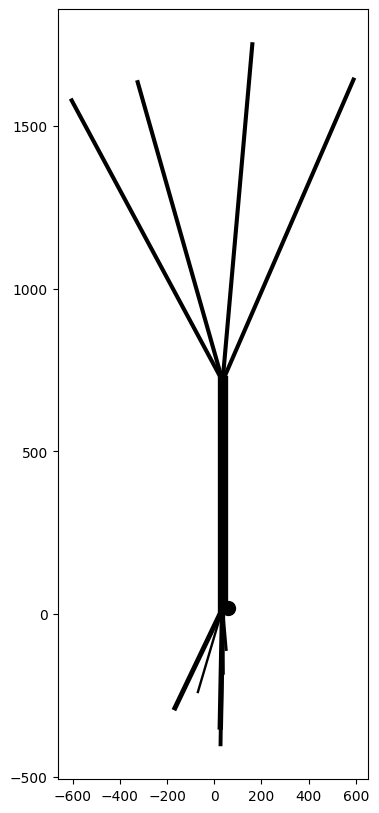

In [43]:
plot_morphology(expanded_segments_df,"expanded_morphology.svg")

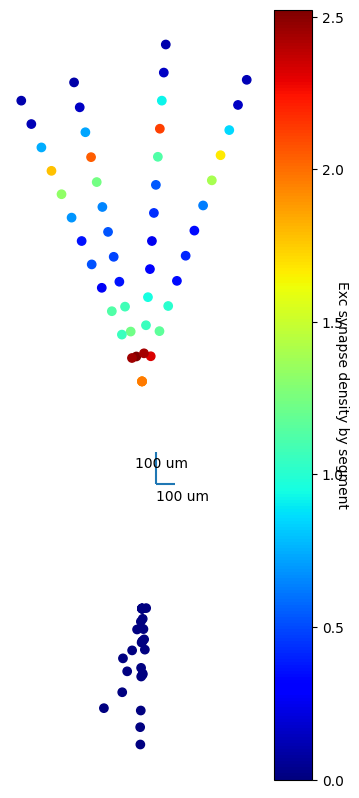

In [51]:
plot_seg_heatmap(df,label="Exc synapse density by segment",
                 savename='exc_syn_density',color_column="exc_NetCon_density")

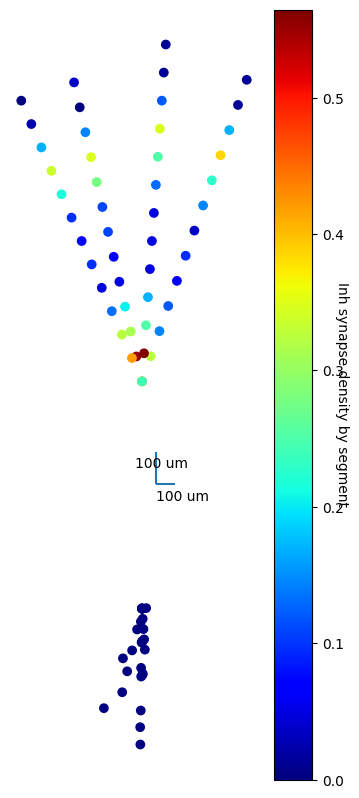

In [45]:
plot_seg_heatmap(df,label="Inh synapse density by segment",
                 savename='inh_syn_density',color_column="inh_NetCon_density")

In [46]:
i_NMDA_df = pd.DataFrame(i_NMDA_bySeg) * 1000

In [47]:
# output files for analysis in another notebook
createsegtracereport('v_report.h5', Vm.T)
createsegtracereport('Ca_HVA.ica_report.h5',icah_data.T)
createsegtracereport('Ca_LVAst.ica_report.h5',ical_data.T)
createsegtracereport('Ih.ihcn_report.h5',ih_data.T)
createsegtracereport('inmda_report.h5',i_NMDA_df.T)
createsegtracereport('NaTa_t.gNaTa_t_report.h5',gNaTa_T_data.T)

In [48]:
%cd ..

/content/Stylized-Single-Cell-and-Extracellular-Potential


In [49]:
#adjust so that a folder is generated for complex and reduced cell and with simulation time as part of the folder name
#maybe include syn distribution in name too